# Conditioning Damped Sinusoids

This notebook is for studies of data conditioning effects for damped sinusoid models, with application to BH ringdown.

Topics include:

* Length of data segment
    - Affects Frequency bin widths, resolution of spikes. Amplitude biases?
* Sample rate
    - What method of downsampling is best? Low SR chops off QNM Lorentzians in FD?
* High and low-pass filtering
    - Dips at low and high frequecies. Digital filter vs. analogue i.e. butterworth. Biases in amplitude and frequency?
* PSD alteration
    - Raise low frequency PSD.
* PSD estimation (length of Welch segments, Welch vs time-domain methods, biased vs unbiased ACF, Bayes Wave?)
    - Welch segments much longer than data segment, but how much longer?

In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import ringdown
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tqdm
import multiprocessing
import arviz as az
import os

#Jupyter notebook imports:
sns.set_context('notebook')
sns.set_palette('colorblind')

rng_seed = 3 # 3 QNMs in GW190521, 3rd First-author paper ;P, 3 authors
rng = np.random.default_rng(rng_seed) # initialize random seed for all random dists

In [3]:
lalxtra_dir = "/mnt/ceph/users/misi/lscsoft/src/lalsuite-extra/data/lalsimulation" #location of lalsuite-extra, to use NRSur7dq4
db_dir = "/mnt/home/hsiegel/ceph/database_rd/" #absolute path of top level dir for database
os.environ["LAL_DATA_PATH"] = lalxtra_dir
import lal
import lalsimulation as ls
from lalsimulation.nrfits import eval_nrfit

## Methods

In [4]:
def damped_sinusoid(A,f,gamma,phase,times,verbose = False, reflect = True):
    #Create a time series for a damped sinusoid.
    #A: float, amplitude
    #f: float, central frequency
    #gamma: float, damping rate
    #phase: float, 0 to 2pi, phase of sinusoid
    #times: array, list of times to calculate damped sinusoid for, starting from peak of signal
    #verbose: bool, if True then print time series of damped sinusoid
    #reflect: bool, if True then reflect damped sinusoid at early times to make a "ring-up"
    
    t0 = times[0]
    times_input = times-t0 # rescale times for damped sinusoid functional input
    sin_func = A*np.cos(2*np.pi*f*times_input+phase)*np.exp(-gamma*times_input)
    if reflect:
        times = np.append(times-times_input[-1]-times_input[1],times)
        times_input = np.append(times_input-times_input[-1]-times_input[1],times_input)
        sin_func = A*np.cos(2*np.pi*f*times_input+phase)*np.exp(-gamma*abs(times_input))
    
    damped_sin = ringdown.TimeSeries(sin_func,times)
    
    if verbose:
        print(damped_sin)
        
    return damped_sin

In [5]:
def white_noise(dur=100, sr=2**14, scale=1.5e-45):
    #Generate white noise for a given length of time and sample rate
    #dur: float, length of time to generate noise for
    #sr: float, sample rate
    #scale: float, magnitude of PSD
    
    N = int(dur * sr)
    delta_t = 1/sr
    freqs = np.fft.rfftfreq(N, delta_t)
    delta_f = freqs[1] - freqs[0]
    times = np.arange(0 , duration, delta_t)
    
    psd = np.ones(len(freqs))*scale
    
    var = psd / (4.*delta_f)
    noise_real = rng.normal(size=len(psd), loc=0, scale=np.sqrt(var))
    noise_imag = rng.normal(size=len(psd), loc=0, scale=np.sqrt(var))
    noise_fd = noise_real + 1j*noise_imag
    
    noise_td = ringdown.TimeSeries(np.fft.irfft(noise_fd) / delta_t,times)
    
    return noise_td

In [6]:
def np2(x): #Get next power of two
    p = 1
    while p <= x:
        p = p << 1
    return p

In [7]:
def laldesignpsd(freqs):
    #freqs: frequencies at which to compute PSD
    #returns ringdown PowerSpectrum of design sensitivity PSD with no signal cavity detuning and high laser power

    laldesignpsd = []
    for x in freqs:
        laldesignpsd.append( ls.SimNoisePSDaLIGOZeroDetHighPower(x))

    if np.isnan(laldesignpsd[0]):
        laldesignpsd[0] = laldesignpsd[1]

    laldesignpsd = ringdown.PowerSpectrum(laldesignpsd, freqs)
    
    return laldesignpsd

In [8]:
def FD_power_whitenoise_LIGOPSD(signal,sample_rate,t0,data_dur,ds):
    signal_FT = np.fft.rfft(signal[t0:t0+data_dur].values)/sample_rate # 0.5 for reflection
    plot_fs = np.fft.rfftfreq(signal[t0:t0+data_dur].index.shape[-1])*sample_rate
    psd = laldesignpsd(plot_fs)
    plt.plot(plot_fs,plot_fs*(signal_FT.real**2+signal_FT.imag**2),color = "black")
    plt.plot(psd, label = "PSD", ls = ":")
    plt.yscale("log")
    plt.xscale("log")
    nyq_freq = sample_rate/(2*ds)
    plt.axvline(nyq_freq, label = "Nyquist",ls="--",color = "green")
    plt.legend()
    plt.title("FT of Signal (Power)")
    sum_fs = []
    for f in plot_fs:
        if f < nyq_freq:
            sum_fs.append(1)
        else:
            sum_fs.append(0)
    snr = np.sum(sum_fs*np.ones(len(plot_fs))/data_dur*(signal_FT.real**2+signal_FT.imag**2)/psd)
    print("SNR =",snr)
    plt.show()

In [9]:
def FD_power_whitenoise_flatPSD(signal,sample_rate,t0,data_dur,ds,psd_scale):
    #psd_scale: float, automatically creates a flat PSD with this value
    signal_FT = np.fft.rfft(signal[t0:t0+data_dur].values)/sample_rate # 0.5 for reflection
    plot_fs = np.fft.rfftfreq(signal[t0:t0+data_dur].index.shape[-1])*sample_rate
    plt.plot(plot_fs,plot_fs*(signal_FT.real**2+signal_FT.imag**2),color = "black")
    psd_plot = ringdown.PowerSpectrum(np.ones(len(plot_fs))*psd_scale, plot_fs)
    plt.plot(plot_fs, psd_plot.values, label = "PSD", ls = ":")
    plt.yscale("log")
    plt.xscale("log")
    nyq_freq = sample_rate/(2*ds)
    plt.axvline(nyq_freq, label = "Nyquist",ls="--",color = "green")
    plt.legend()
    plt.title("FT of Signal (Power)")
    sum_fs = []
    for f in plot_fs:
        if f < nyq_freq:
            sum_fs.append(1)
        else:
            sum_fs.append(0)
    snr = np.sum(sum_fs*np.ones(len(plot_fs))/data_dur*(signal_FT.real**2+signal_FT.imag**2)/psd_plot)
    print("SNR =",snr)
    plt.show()

In [10]:
def FD_power_whitenoise_flatspikePSD(signal,sample_rate,t0,data_dur,ds,psd_scale,spike_amp,spike_std,spike_mean):
    #psd_scale: float, automatically creates a flat PSD with this value
    signal_FT = np.fft.rfft(signal[t0:t0+data_dur].values)/sample_rate # 0.5 for reflection
    plot_fs = np.fft.rfftfreq(signal[t0:t0+data_dur].index.shape[-1])*sample_rate
    plt.plot(plot_fs,plot_fs*(signal_FT.real**2+signal_FT.imag**2),color = "black")
    psd = np.ones(len(plot_fs))*psd_scale + spike_amp*np.exp(-(plot_fs-spike_mean)**2/spike_std)
    psd_plot = ringdown.PowerSpectrum(psd, plot_fs)
    plt.plot(plot_fs, psd, label = "PSD", ls = ":")
    plt.yscale("log")
    plt.xscale("log")
    nyq_freq = sample_rate/(2*ds)
    plt.axvline(nyq_freq, label = "Nyquist",ls="--",color = "green")
    plt.legend()
    plt.title("FT of Signal (Power)")
    sum_fs = []
    for f in plot_fs:
        if f < nyq_freq:
            sum_fs.append(1)
        else:
            sum_fs.append(0)
    snr = np.sum(sum_fs*np.ones(len(plot_fs))/data_dur*(signal_FT.real**2+signal_FT.imag**2)/psd_plot)
    print("SNR =",snr)
    plt.show()

# GW150914-like signal, different downsampling

## fundamental only, analysis duration = 0.05 seconds, no-noise injection, flat PSD

Analysis segment duration = 0.05
Running with downsampling 1
SNR = 13.893674877762383


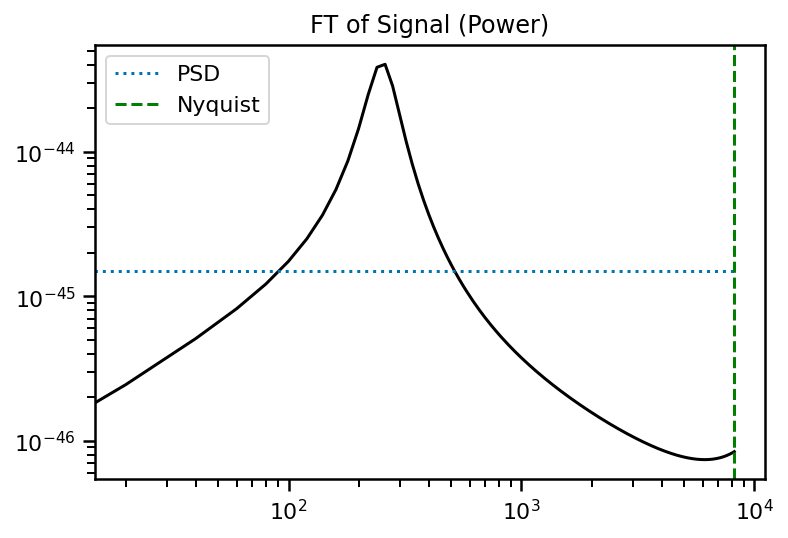

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 873 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 873 seconds.


Analysis segment duration = 0.05006103515625
Running with downsampling 4
SNR = 13.805528669054796


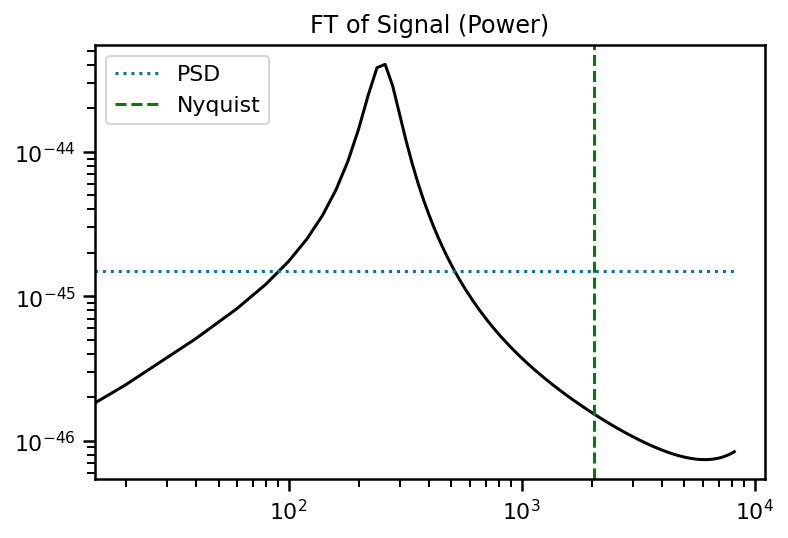

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 240 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 240 seconds.


Analysis segment duration = 0.05030517578125
Running with downsampling 8
SNR = 13.695867578542117


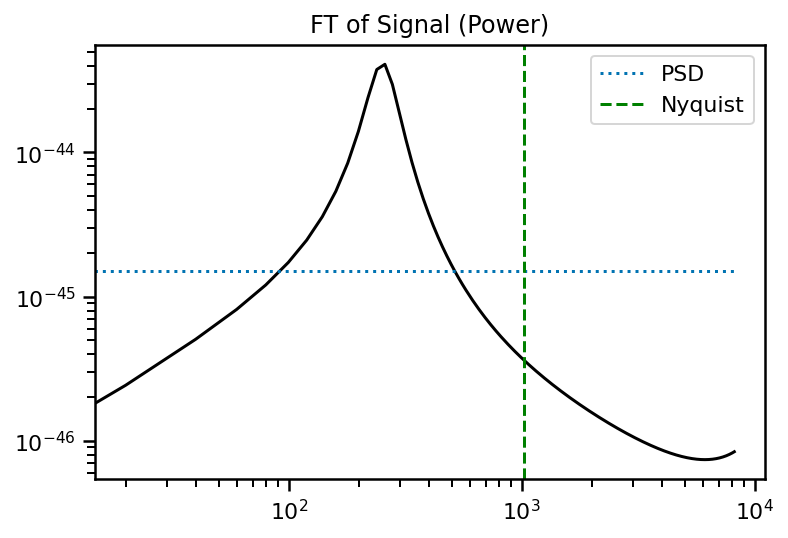

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 222 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 222 seconds.


Analysis segment duration = 0.05
Running with downsampling 16
SNR = 13.34616040528727


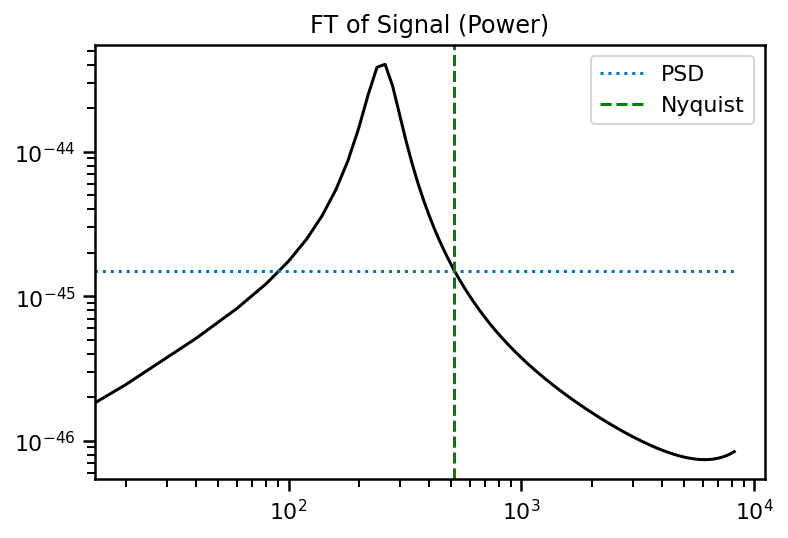

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 195 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 195 seconds.


Analysis segment duration = 0.05128173828125
Running with downsampling 24
SNR = 12.375696487493084


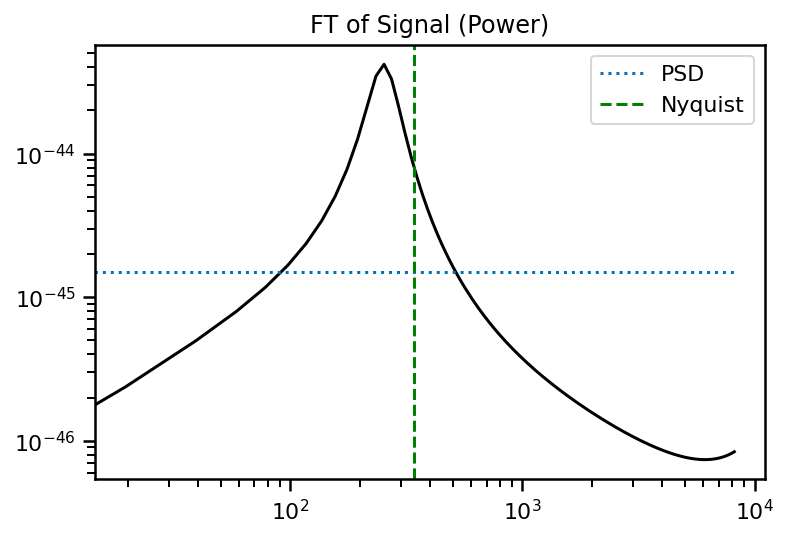

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 223 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 223 seconds.


In [11]:
fit_dict_fundamental = {}
ds_list = [1,4,8,16,24] # amounts we will downsample by in each analysis

psd_scale = 1.5e-45
sample_rate = 2**14
duration = 100
noise_td  = white_noise(scale=psd_scale)
times = noise_td.index
draws = 2000 #number of samples per chain

f_qnm = 250 # https://arxiv.org/pdf/2107.05609.pdf Table 1
A = 3e-21*2
tau_qnm = 4e-3
phase_qnm = 5.34 # radians
signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

#analysis_data = noise_td + signal
analysis_data = signal

delta_t = 1/sample_rate
t0 = duration/2

for ds in ds_list:
    analysis_data_cond = ringdown.Data(analysis_data,noise_td.index)
    analysis_data_cond = analysis_data_cond.condition(t0=t0,ds=ds,digital_filter = True)
    #fit = ringdown.Fit('ftau', modes=1)
    #fit = ringdown.Fit('mchi', modes = [(1, -2, 2, 2, 0)])
    fit = ringdown.Fit(model='mchi_marginal', modes=[(1, -2, 2, 2, 0)])
    
    
    incr = 0
    running = False
    while not running:
        data_dur = 0.05+incr*delta_t
        freqs_analysis = np.fft.rfftfreq(len(analysis_data_cond[t0:t0+data_dur]), delta_t*ds)
        psd_analysis = ringdown.PowerSpectrum(np.ones(len(freqs_analysis))*psd_scale,freqs_analysis)
        acf_analysis = psd_analysis.to_acf()
        fit.add_data(analysis_data_cond[t0:t0+data_dur], acf=acf_analysis, ifo='X')
        fit.set_target(t0, duration=data_dur)
        fit.update_prior(A_scale_max=10*A, M_min=35.0, M_max=140.0)
        if incr>ds*2:
            raise ValueError("Something is broken in this loop")
        elif len(fit.data[None])!=len(fit.acfs[None]):
            incr+=1
        else:
            running = True
    print("Analysis segment duration =",data_dur)
    print("Running with downsampling",ds)
    
    FD_power_whitenoise_flatPSD(signal,sample_rate,t0,data_dur,ds,psd_scale)
    fit.run(draws = draws)
    fit_dict_fundamental[ds] = fit

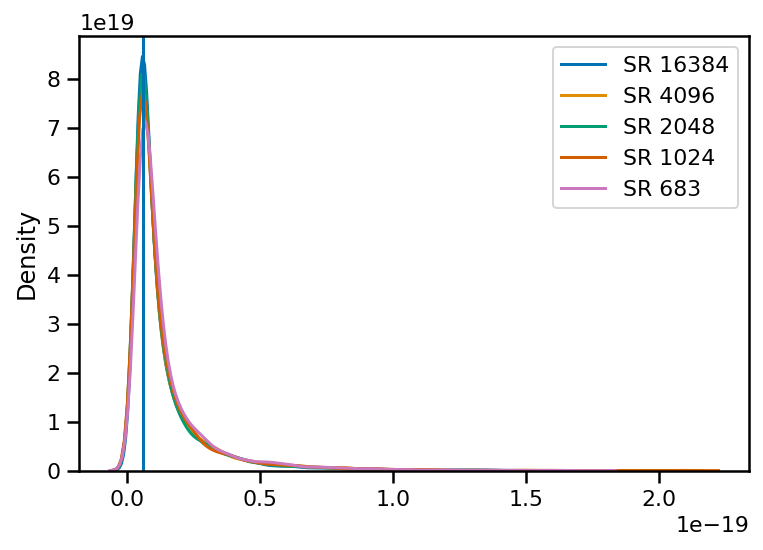

In [12]:
for k,v in fit_dict_fundamental.items():
    sns.kdeplot(v.result.posterior.A.values.flatten(),label = "SR " + "{:.0f}".format(sample_rate/k))
    
plt.axvline(3e-21*2)
plt.legend()

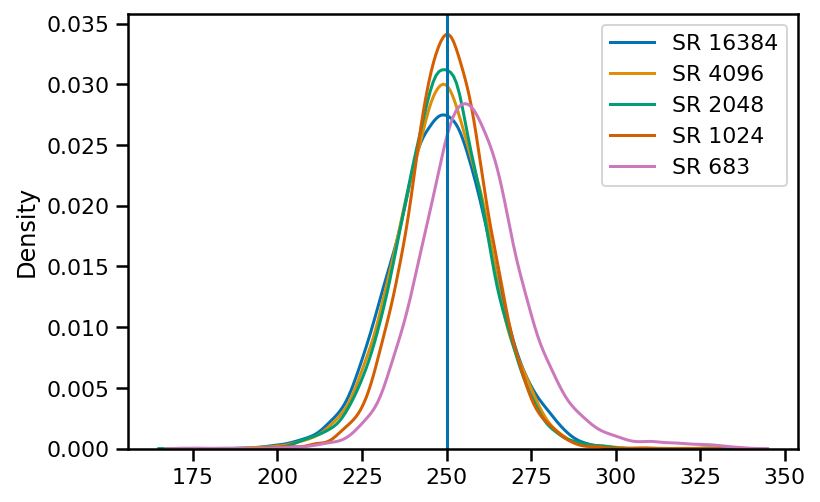

In [13]:
for k,v in fit_dict_fundamental.items():
    sns.kdeplot(v.result.posterior.f.values.flatten(),label = "SR " + "{:.0f}".format(sample_rate/k))
    
plt.axvline(250)
plt.legend(loc = "upper right")

### LIGO Design PSD

SNR = 14.855244248031445


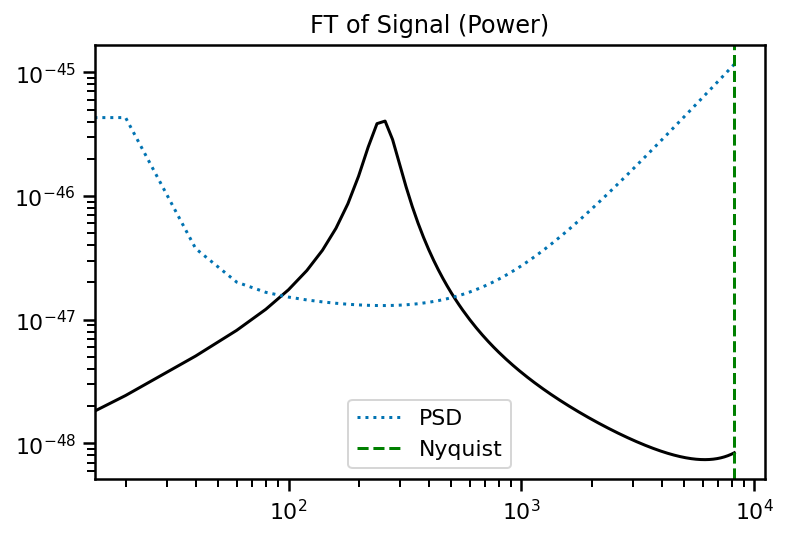

Analysis segment duration = 0.05
Running with downsampling 1


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 764 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 764 seconds.


SNR = 14.848403831255634


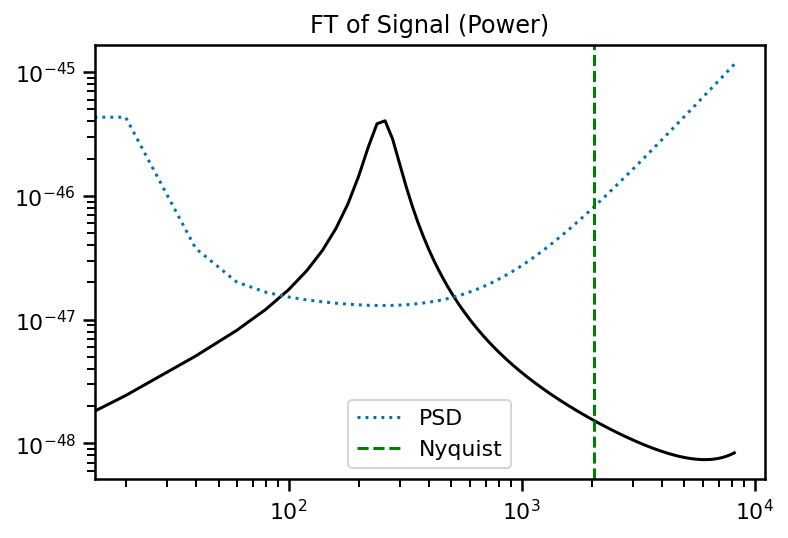

Analysis segment duration = 0.05006103515625
Running with downsampling 4


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 235 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 235 seconds.


SNR = 14.808525161603303


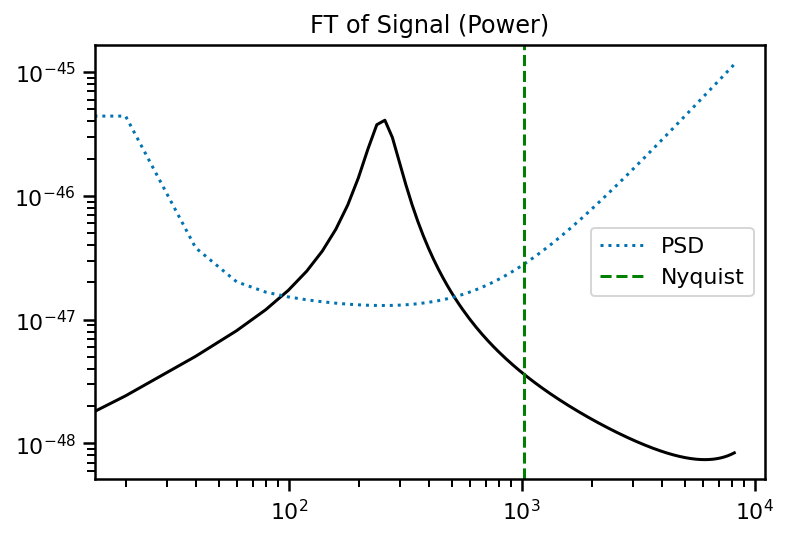

Analysis segment duration = 0.05030517578125
Running with downsampling 8


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 209 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 209 seconds.


SNR = 14.519931371850323


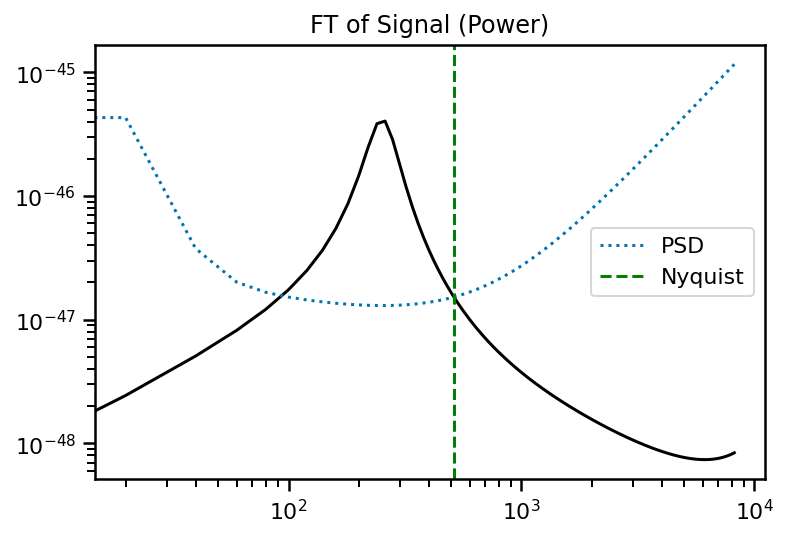

Analysis segment duration = 0.05
Running with downsampling 16


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 198 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 198 seconds.


SNR = 13.469541281813118


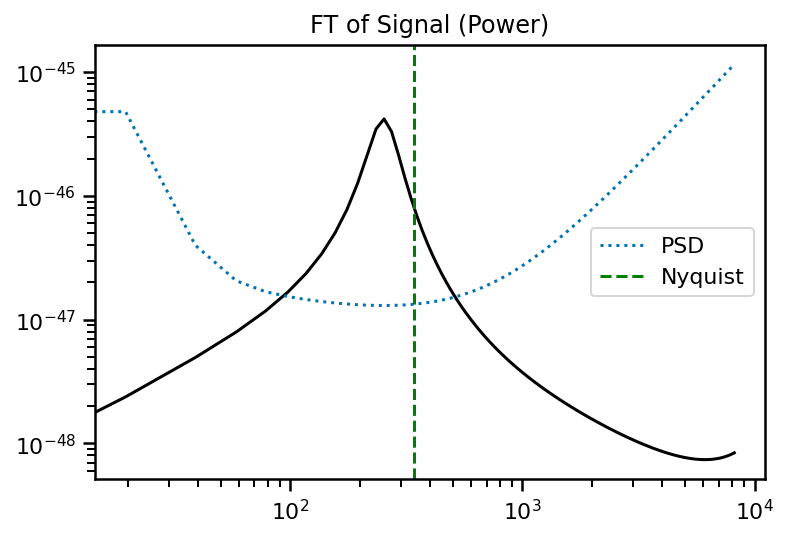

Analysis segment duration = 0.05128173828125
Running with downsampling 24


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 366 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 366 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6941, but should be close to 0.9. Try to increase the number of tuning steps.


In [14]:
fit_dict_fundamental_LIGOPSD = {}
ds_list = [1,4,8,16,24] # amounts we will downsample by in each analysis

sample_rate = 2**14
duration = 100
noise_td  = white_noise(scale=psd_scale)
times = noise_td.index
draws = 2000 #number of samples per chain

f_qnm = 250 # https://arxiv.org/pdf/2107.05609.pdf Table 1
A = 3e-22*2
tau_qnm = 4e-3
phase_qnm = 5.34 # radians
signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

#analysis_data = noise_td + signal
analysis_data = signal

delta_t = 1/sample_rate
t0 = duration/2


for ds in ds_list:
    analysis_data_cond = ringdown.Data(analysis_data,noise_td.index)
    analysis_data_cond = analysis_data_cond.condition(t0=t0,ds=ds,digital_filter = True)
    #fit = ringdown.Fit('ftau', modes=1)
    #fit = ringdown.Fit('mchi', modes = [(1, -2, 2, 2, 0)])
    fit = ringdown.Fit(model='mchi_marginal', modes=[(1, -2, 2, 2, 0)])
    
    incr = 0
    running = False
    while not running:
        data_dur = 0.05+incr*delta_t
        freqs_analysis = np.fft.rfftfreq(len(analysis_data_cond[t0:t0+data_dur]), delta_t*ds)
        psd_analysis = laldesignpsd(freqs_analysis)
        acf_analysis = psd_analysis.to_acf()
        fit.add_data(analysis_data_cond[t0:t0+data_dur], acf=acf_analysis, ifo='X')
        fit.set_target(t0, duration=data_dur)
        fit.update_prior(A_scale_max=10*A, M_min=35.0, M_max=140.0)
        if incr>ds*2:
            raise ValueError("Something is broken in this loop")
        elif len(fit.data[None])!=len(fit.acfs[None]):
            incr+=1
        else:
            running = True

    FD_power_whitenoise_LIGOPSD(signal,sample_rate,t0,data_dur,ds)        
    print("Analysis segment duration =",data_dur)
    print("Running with downsampling",ds)
    
    fit.run(draws=draws)
    fit_dict_fundamental_LIGOPSD[ds] = fit

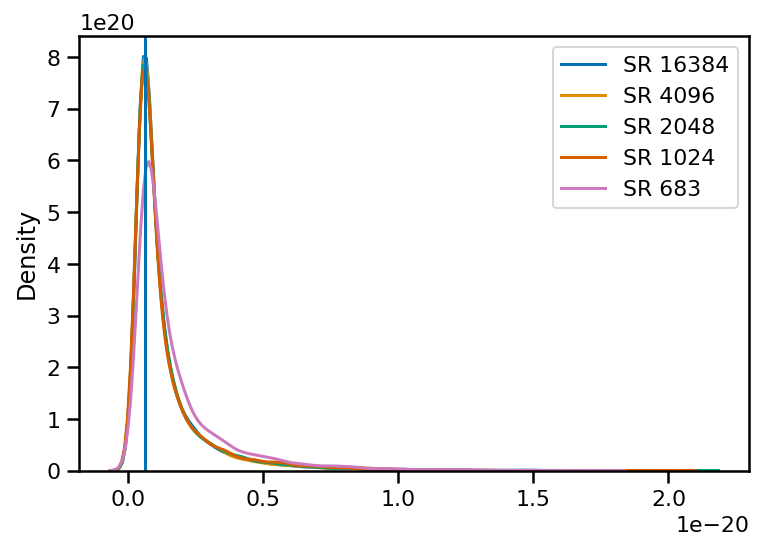

In [15]:
for k,v in fit_dict_fundamental_LIGOPSD.items():
    sns.kdeplot(v.result.posterior.A.values.flatten(),label = "SR " + "{:.0f}".format(sample_rate/k))
    
A = 3e-22*2
plt.axvline(A)
plt.legend()

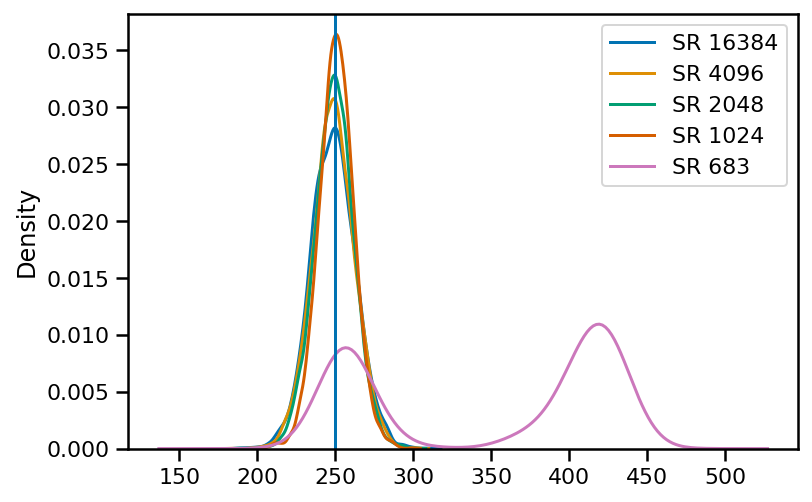

In [16]:
for k,v in fit_dict_fundamental_LIGOPSD.items():
    sns.kdeplot(v.result.posterior.f.values.flatten(),label = "SR " + "{:.0f}".format(sample_rate/k))
    
plt.axvline(250)
plt.legend(loc = "upper right")

### Flat PSD with Spike

<Axes: >

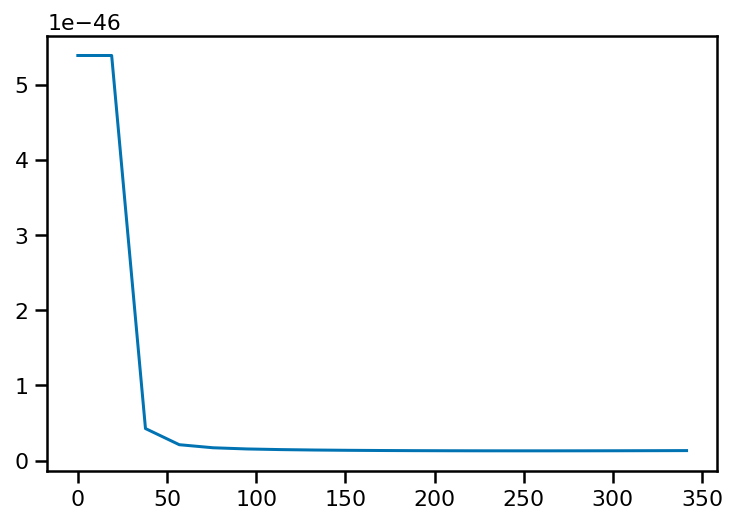

In [17]:
psd_analysis.plot()

Analysis segment duration = 0.05
Running with downsampling 1
SNR = 10.517509604294585


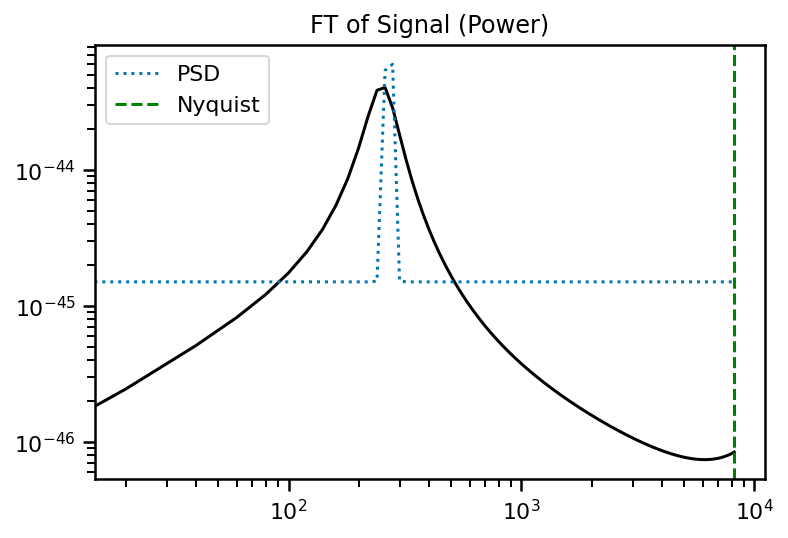

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 660 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 660 seconds.


Analysis segment duration = 0.05030517578125
Running with downsampling 8
SNR = 10.247606298930727


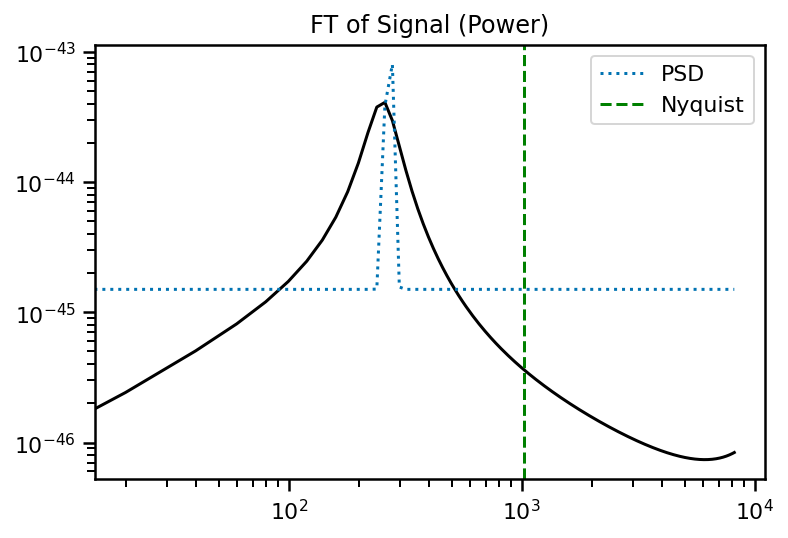

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 170 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 170 seconds.


Analysis segment duration = 0.05128173828125
Running with downsampling 24
SNR = 8.568450554930344


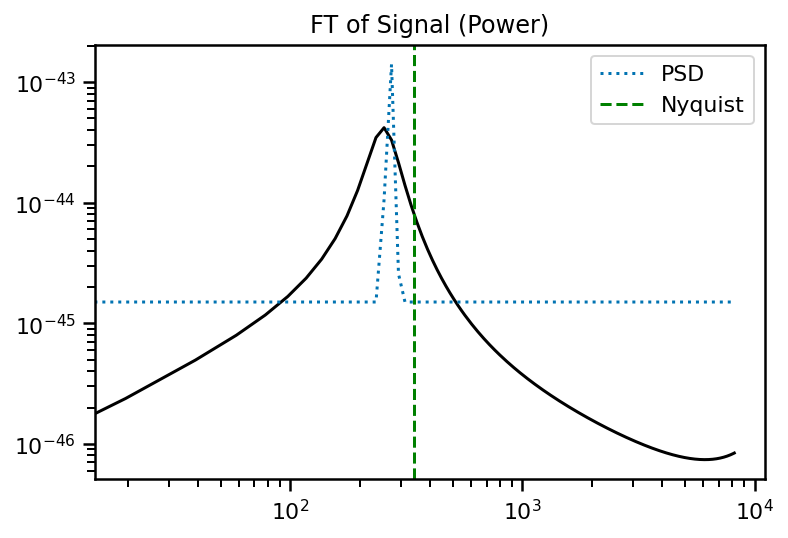

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 279 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 279 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


In [18]:
fit_dict_fundamental_spike = {}
ds_list = [1,8,24] # amounts we will downsample by in each analysis

psd_scale = 1.5e-45
sample_rate = 2**14
duration = 100
noise_td = white_noise(scale=psd_scale)
times = noise_td.index
draws = 2000 #number of samples per chain

f_qnm = 250 # https://arxiv.org/pdf/2107.05609.pdf Table 1
A = 3e-21*2
tau_qnm = 4e-3
phase_qnm = 5.34 # radians
signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

#analysis_data = noise_td + signal
analysis_data = signal

delta_t = 1/sample_rate
t0 = duration/2

# parameters of spike in PSD
spike_std = 100
spike_mean = 270
spike_amp = 100*psd_scale

for ds in ds_list:
    analysis_data_cond = ringdown.Data(analysis_data,noise_td.index)
    analysis_data_cond = analysis_data_cond.condition(t0=t0,ds=ds,digital_filter = True)
    #fit = ringdown.Fit('ftau', modes=1)
    #fit = ringdown.Fit('mchi', modes = [(1, -2, 2, 2, 0)])
    fit = ringdown.Fit(model='mchi_marginal', modes=[(1, -2, 2, 2, 0)])
    
    
    incr = 0
    running = False
    while not running:
        data_dur = 0.05+incr*delta_t
        freqs_analysis = np.fft.rfftfreq(len(analysis_data_cond[t0:t0+data_dur]), delta_t*ds)
        psd_analysis = ringdown.PowerSpectrum(np.ones(len(freqs_analysis))*psd_scale,freqs_analysis)
        psd_analysis += spike_amp*np.exp(-(psd_analysis.index-spike_mean)**2/spike_std)
        acf_analysis = psd_analysis.to_acf()
        fit.add_data(analysis_data_cond[t0:t0+data_dur], acf=acf_analysis, ifo='X')
        fit.set_target(t0, duration=data_dur)
        fit.update_prior(A_scale_max=10*A, M_min=35.0, M_max=140.0)
        if incr>ds*2:
            raise ValueError("Something is broken in this loop")
        elif len(fit.data[None])!=len(fit.acfs[None]):
            incr+=1
        else:
            running = True
    print("Analysis segment duration =",data_dur)
    print("Running with downsampling",ds)
    
    FD_power_whitenoise_flatspikePSD(signal,sample_rate,t0,data_dur,ds,psd_scale,spike_amp,spike_std,spike_mean)
    fit.run(draws = draws)
    fit_dict_fundamental_spike[ds] = fit

## overtone only, analysis duration = 0.05 seconds, no-noise injection, flat PSD

Analysis segment duration = 0.05
Running with downsampling 1
SNR = 10.14537468380147


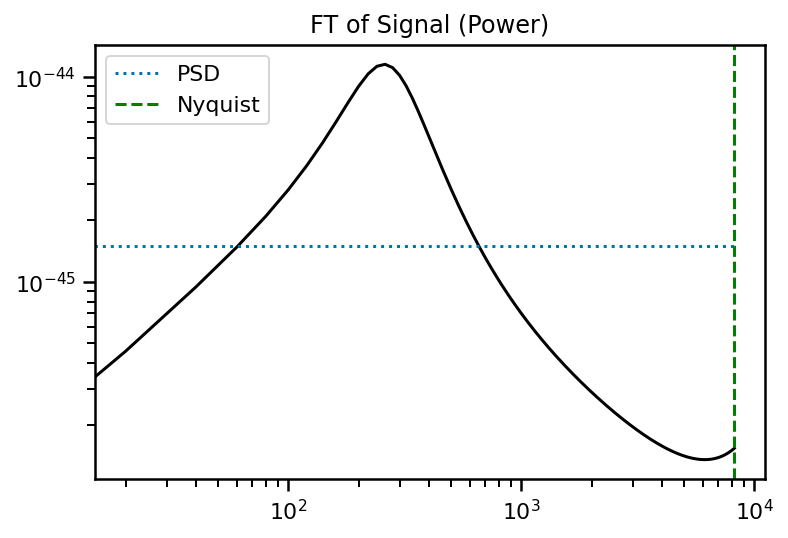

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 654 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 654 seconds.


Analysis segment duration = 0.05006103515625
Running with downsampling 4
SNR = 9.983123973591185


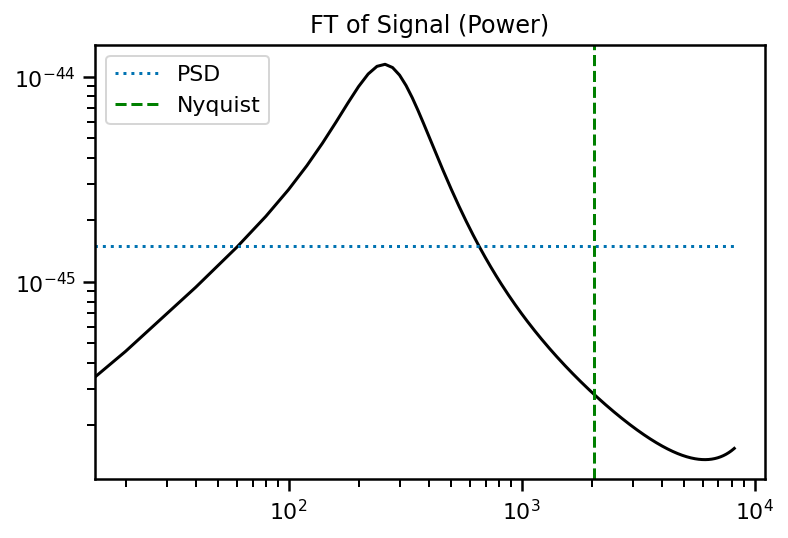

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 185 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 185 seconds.


Analysis segment duration = 0.05030517578125
Running with downsampling 8
SNR = 9.779356214225121


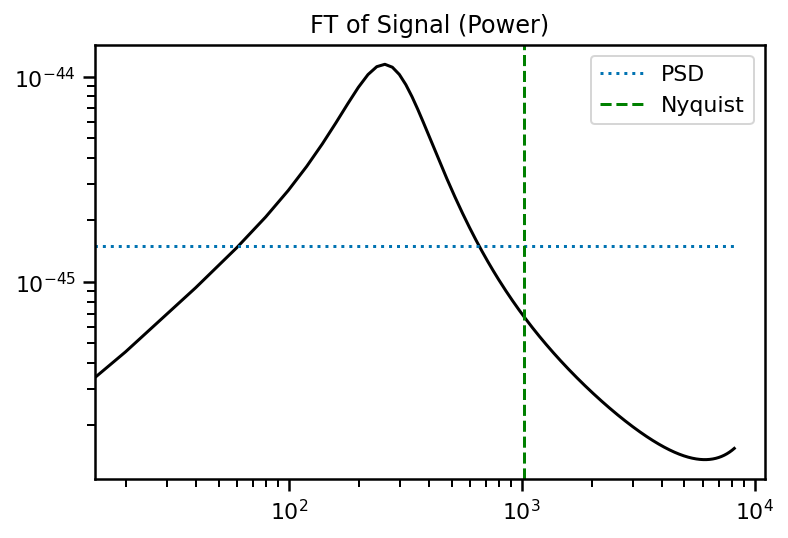

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 151 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 151 seconds.


Analysis segment duration = 0.05
Running with downsampling 16
SNR = 9.14277436612952


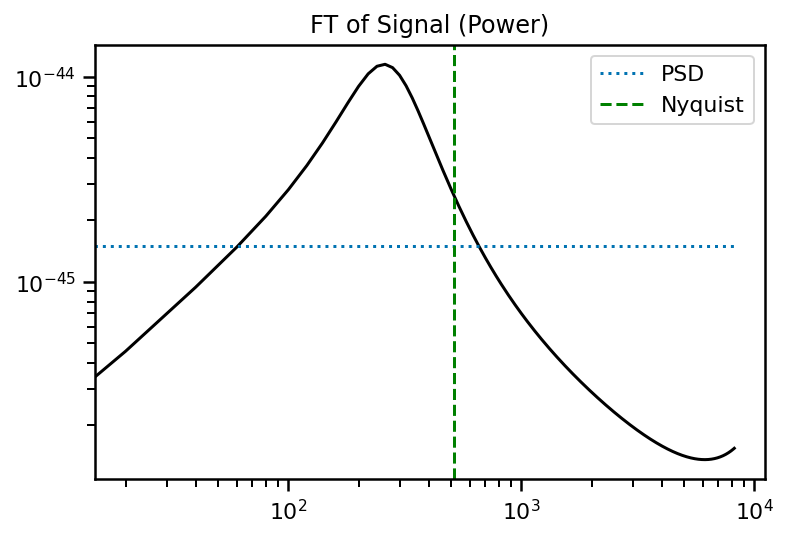

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 184 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 184 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Analysis segment duration = 0.05128173828125
Running with downsampling 24
SNR = 7.854388007915349


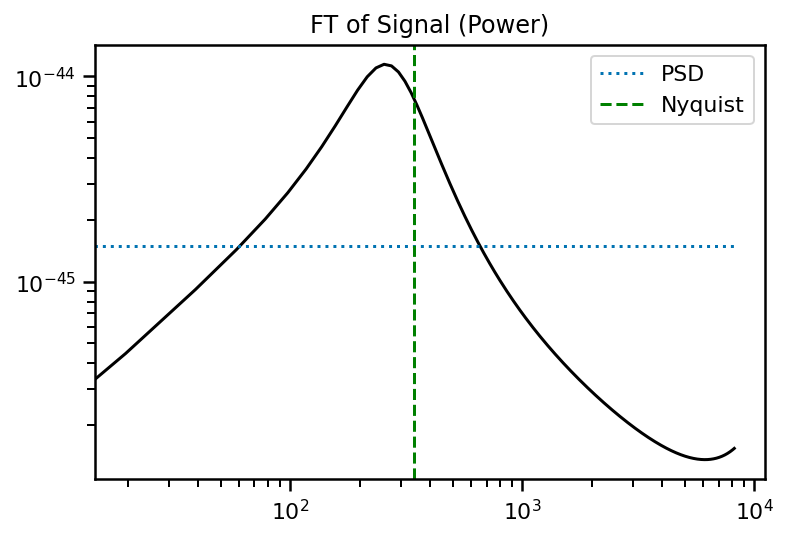

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, chi, df, dtau, A_scale, Apx_unit, Apy_unit, Acx_unit, Acy_unit]


In [ ]:
fit_dict_overtone = {}
ds_list = [1,4,8,16,24] # amounts we will downsample by in each analysis

psd_scale = 1.5e-45
sample_rate = 2**14
duration = 100
noise_td  = white_noise(scale=psd_scale)
times = noise_td.index
draws = 2000 #number of samples per chain

f_qnm = 245 # https://arxiv.org/pdf/2107.05609.pdf Table 1
A = 4e-21*2
tau_qnm = 1.4e-3
phase_qnm = 5.34 # radians
signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

#analysis_data = noise_td + signal
analysis_data = signal

delta_t = 1/sample_rate
t0 = duration/2

for ds in ds_list:
    analysis_data_cond = ringdown.Data(analysis_data,noise_td.index)
    analysis_data_cond = analysis_data_cond.condition(t0=t0,ds=ds,digital_filter = True)
    #fit = ringdown.Fit('ftau', modes=1)
    #fit = ringdown.Fit('mchi', modes = [(1, -2, 2, 2, 0)])
    fit = ringdown.Fit(model='mchi_marginal', modes=[(1, -2, 2, 2, 1)])
    
    incr = 0
    running = False
    while not running:
        data_dur = 0.05+incr*delta_t
        freqs_analysis = np.fft.rfftfreq(len(analysis_data_cond[t0:t0+data_dur]), delta_t*ds)
        psd_analysis = ringdown.PowerSpectrum(np.ones(len(freqs_analysis))*psd_scale,freqs_analysis)
        acf_analysis = psd_analysis.to_acf()
        fit.add_data(analysis_data_cond[t0:t0+data_dur], acf=acf_analysis, ifo='X')
        fit.set_target(t0, duration=data_dur)
        fit.update_prior(A_scale_max=10*A, M_min=35.0, M_max=140.0)
        if incr>ds*2:
            raise ValueError("Something is broken in this loop")
        elif len(fit.data[None])!=len(fit.acfs[None]):
            incr+=1
        else:
            running = True
    print("Analysis segment duration =",data_dur)
    print("Running with downsampling",ds)
    
    FD_power_whitenoise_flatPSD(signal,sample_rate,t0,data_dur,ds,psd_scale)
    fit.run(draws=draws)
    fit_dict_overtone[ds] = fit

In [ ]:
for k,v in fit_dict_overtone.items():
    sns.kdeplot(v.result.posterior.A.values.flatten(),label = "SR " + str(sample_rate/k))
plt.legend()

## overtone and fundamental, analysis duration = 0.05 seconds, no-noise injection, flat PSD

In [ ]:
fit_dict_2modes = {}
ds_list = [1,4,8,16,24] # amounts we will downsample by in each analysis

psd_scale = 1.5e-45
sample_rate = 2**14
duration = 100
noise_td  = white_noise(scale=psd_scale)
times = noise_td.index
draws = 2000 #number of samples per chain

f_qnm = 245 # https://arxiv.org/pdf/2107.05609.pdf Table 1
A = 4e-21
tau_qnm = 1.4e-3
phase_qnm = 5.34 # radians
signal1 = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

f_qnm = 250 # https://arxiv.org/pdf/2107.05609.pdf Table 1
A = 3e-21
tau_qnm = 4e-3
phase_qnm = 5.34 # radians
signal2 = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

signal = signal1+signal2

#analysis_data = noise_td + signal
analysis_data = signal

delta_t = 1/sample_rate
t0 = duration/2

for ds in ds_list:
    analysis_data_cond = ringdown.Data(analysis_data,noise_td.index)
    analysis_data_cond = analysis_data_cond.condition(t0=t0,ds=ds,digital_filter = True)
    #fit = ringdown.Fit('ftau', modes=2)
    #fit = ringdown.Fit('mchi', modes = [(1, -2, 2, 2, 0),(1, -2, 2, 2, 1)])
    fit = ringdown.Fit(model='mchi_marginal', modes=[(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)])
    
    incr = 0
    running = False
    while not running:
        data_dur = 0.05+incr*delta_t
        freqs_analysis = np.fft.rfftfreq(len(analysis_data_cond[t0:t0+data_dur]), delta_t*ds)
        psd_analysis = ringdown.PowerSpectrum(np.ones(len(freqs_analysis))*psd_scale,freqs_analysis)
        acf_analysis = psd_analysis.to_acf()
        fit.add_data(analysis_data_cond[t0:t0+data_dur], acf=acf_analysis, ifo='X')
        fit.set_target(t0, duration=data_dur)
        fit.update_prior(A_scale_max=10*A, M_min=35.0, M_max=140.0)
        if incr>ds*2:
            raise ValueError("Something is broken in this loop")
        elif len(fit.data[None])!=len(fit.acfs[None]):
            incr+=1
        else:
            running = True
    print("Analysis segment duration =",data_dur)
    print("Running with downsampling",ds)
    
    FD_power_whitenoise_flatPSD(signal,sample_rate,t0,data_dur,ds,psd_scale)
    fit.run(draws = draws)
    fit_dict_2modes[ds] = fit

In [ ]:
for k,v in fit_dict_2modes.items():
    sns.kdeplot(v.result.posterior.A.values.T[0].flatten(),label = "SR " + "{:.0f}".format(sample_rate/k))
plt.legend()

In [ ]:
for k,v in fit_dict_2modes.items():
    sns.kdeplot(v.result.posterior.A.values.T[1].flatten(),label = "SR " + "{:.0f}".format(sample_rate/k))
plt.legend()

In [ ]:
for k,v in fit_dict_2modes.items():
    sns.kdeplot(v.result.posterior.f.values.T[1].flatten(),label = "SR " + "{:.0f}".format(sample_rate/k))
plt.legend()

## Fit Power Freq Domain

### Fundamental, flat PSD

In [ ]:
fig = plt.figure(figsize=[10,10])
quantile = .9

f_qnm = 250 # https://arxiv.org/pdf/2107.05609.pdf Table 1
A = 3e-21*2
tau_qnm = 4e-3
phase_qnm = 5.34 # radians
signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

colors = sns.color_palette("colorblind")
cnt = 0
for k,f in fit_dict_fundamental.items():
    if k in [4,8]:
        continue
    
    plot_fs = np.fft.rfftfreq(f.result.posterior.h_det[0][0][0].values.shape[-1])*sample_rate/k
    
    if k == 1:
        psd_fs = plot_fs
        
    signal_FT_list = []
    
    for i in np.arange(100):
        sig_fit=f.result.posterior.h_det[0][i][0].values
        signal_FT = np.fft.rfft(sig_fit)/sample_rate*k #0.5 for reflection
        signal_FT_list.append(plot_fs*(signal_FT.real**2+signal_FT.imag**2))
    
    plt.axvline((sample_rate/k)/2, label = "SR "+"{:.0f}".format(sample_rate/k),ls="-",color = colors[cnt],lw=4,alpha = 0.5)
    
    m = ringdown.FrequencySeries(data=np.quantile(signal_FT_list,0.5,axis = 0),index = plot_fs)
    u = ringdown.FrequencySeries(data=np.quantile(signal_FT_list,0.5-quantile/2,axis = 0),index = plot_fs)
    d = ringdown.FrequencySeries(data=np.quantile(signal_FT_list,0.5+quantile/2,axis = 0),index = plot_fs)

    up, = plt.plot(u,color=colors[cnt],alpha = 0.7,lw=2)
    dp, = plt.plot(d,color=colors[cnt],alpha = 0.7,lw=2)
    #mp, = plt.plot(m,color=colors[cnt],alpha = 0.7)
    plt.fill_between(plot_fs,u,d,color=colors[cnt],alpha=0.15,zorder=cnt)
    cnt+=1

    
psd_plot = ringdown.PowerSpectrum(np.ones(len(psd_fs))*psd_scale,psd_fs)
plt.plot(psd_fs, psd_plot.values, label = "PSD",ls = "--",lw=2.5,color="black",alpha=0.8)

signal_FT = np.fft.rfft(signal[t0:t0+data_dur].values)/sample_rate # 0.5 for reflection
plot_fs = np.fft.rfftfreq(signal[t0:t0+data_dur].index.shape[-1])*sample_rate
plt.plot(plot_fs,plot_fs*(signal_FT.real**2+signal_FT.imag**2),color = "black",label = "Injected Signal",lw=4)

plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.ylim(1e-46,1e-43)
plt.title("FT of Signal (Power), 1 Fundamental Mode GW150914")

### Fundamental, LIGO PSD

In [ ]:
fig = plt.figure(figsize=[10,10])
quantile = .9

f_qnm = 250 # https://arxiv.org/pdf/2107.05609.pdf Table 1
A = 3e-22*2
tau_qnm = 4e-3
phase_qnm = 5.34 # radians
signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

colors = sns.color_palette("colorblind")
cnt = 0
for k,f in fit_dict_fundamental_LIGOPSD.items():
    if k in [4,8]:
        continue
    
    plot_fs = np.fft.rfftfreq(f.result.posterior.h_det[0][0][0].values.shape[-1])*sample_rate/k
    
    if k == 1:
        psd_fs = plot_fs
        
    signal_FT_list = []
    
    for i in np.arange(100):
        sig_fit=f.result.posterior.h_det[0][i][0].values
        signal_FT = np.fft.rfft(sig_fit)/sample_rate*k #0.5 for reflection
        signal_FT_list.append(plot_fs*(signal_FT.real**2+signal_FT.imag**2))
    
    plt.axvline((sample_rate/k)/2, label = "SR "+"{:.0f}".format(sample_rate/k),ls="-",color = colors[cnt],lw=4,alpha = 0.5)
    
    m = ringdown.FrequencySeries(data=np.quantile(signal_FT_list,0.5,axis = 0),index = plot_fs)
    u = ringdown.FrequencySeries(data=np.quantile(signal_FT_list,0.5-quantile/2,axis = 0),index = plot_fs)
    d = ringdown.FrequencySeries(data=np.quantile(signal_FT_list,0.5+quantile/2,axis = 0),index = plot_fs)

    up, = plt.plot(u,color=colors[cnt],alpha = 0.7,lw=2)
    dp, = plt.plot(d,color=colors[cnt],alpha = 0.7,lw=2)
    #mp, = plt.plot(m,color=colors[cnt],alpha = 0.7)
    plt.fill_between(plot_fs,u,d,color=colors[cnt],alpha=0.15,zorder=cnt)
    cnt+=1

    
psd_plot = ringdown.PowerSpectrum(laldesignpsd(psd_fs),psd_fs)
plt.plot(psd_fs, psd_plot.values, label = "PSD",ls = "--",lw=2.5,color="black",alpha=0.8)

signal_FT = np.fft.rfft(signal[t0:t0+data_dur].values)/sample_rate # 0.5 for reflection
plot_fs = np.fft.rfftfreq(signal[t0:t0+data_dur].index.shape[-1])*sample_rate
plt.plot(plot_fs,plot_fs*(signal_FT.real**2+signal_FT.imag**2),color = "black",label = "Injected Signal",lw=4)

plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.ylim(1e-48,1e-45)
plt.title("FT of Signal (Power), 1 Fundamental Mode GW150914")

### Overtone, flat PSD

In [ ]:
fig = plt.figure(figsize=[10,10])
quantile = .9

f_qnm = 245 # https://arxiv.org/pdf/2107.05609.pdf Table 1
A = 4e-21*2
tau_qnm = 1.4e-3
phase_qnm = 5.34 # radians
signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

colors = sns.color_palette("colorblind")
cnt = 0
for k,f in fit_dict_overtone.items():
    if k in [4,8]:
        continue
    
    plot_fs = np.fft.rfftfreq(f.result.posterior.h_det[0][0][0].values.shape[-1])*sample_rate/k
    
    if k == 1:
        psd_fs = plot_fs
        
    signal_FT_list = []
    
    for i in np.arange(100):
        sig_fit=f.result.posterior.h_det[0][i][0].values
        signal_FT = np.fft.rfft(sig_fit)/sample_rate*k #0.5 for reflection
        signal_FT_list.append(plot_fs*(signal_FT.real**2+signal_FT.imag**2))
    
    plt.axvline((sample_rate/k)/2, label = "SR "+"{:.0f}".format(sample_rate/k),ls="-",color = colors[cnt],lw=4,alpha = 0.5)
    
    m = ringdown.FrequencySeries(data=np.quantile(signal_FT_list,0.5,axis = 0),index = plot_fs)
    u = ringdown.FrequencySeries(data=np.quantile(signal_FT_list,0.5-quantile/2,axis = 0),index = plot_fs)
    d = ringdown.FrequencySeries(data=np.quantile(signal_FT_list,0.5+quantile/2,axis = 0),index = plot_fs)

    up, = plt.plot(u,color=colors[cnt],alpha = 0.7,lw=2)
    dp, = plt.plot(d,color=colors[cnt],alpha = 0.7,lw=2)
    #mp, = plt.plot(m,color=colors[cnt],alpha = 0.7)
    plt.fill_between(plot_fs,u,d,color=colors[cnt],alpha=0.15,zorder=cnt)
    cnt+=1

    
psd_plot = ringdown.PowerSpectrum(np.ones(len(psd_fs))*psd_scale,psd_fs)
plt.plot(psd_fs, psd_plot.values, label = "PSD",ls = "--",lw=2.5,color="black",alpha=0.8)

signal_FT = np.fft.rfft(signal[t0:t0+data_dur].values)/sample_rate # 0.5 for reflection
plot_fs = np.fft.rfftfreq(signal[t0:t0+data_dur].index.shape[-1])*sample_rate
plt.plot(plot_fs,plot_fs*(signal_FT.real**2+signal_FT.imag**2),color = "black",label = "Injected Signal",lw=4)

plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.ylim(1e-46,5e-44)
plt.title("FT of Signal (Power), 1st Overtone GW150914")

### Fundamental and Overtone, flat PSD

In [ ]:
fig = plt.figure(figsize=[10,10])
quantile = .9

f_qnm = 245 # https://arxiv.org/pdf/2107.05609.pdf Table 1
A = 4e-21
tau_qnm = 1.4e-3
phase_qnm = 5.34 # radians
signal1 = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

f_qnm = 250 # https://arxiv.org/pdf/2107.05609.pdf Table 1
A = 3e-21
tau_qnm = 4e-3
phase_qnm = 5.34 # radians
signal2 = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

signal = signal1+signal2

colors = sns.color_palette("colorblind")
cnt = 0
psd_fs = []

for k,f in fit_dict_2modes.items():
    if k in [4,8]:
        continue
    
    plot_fs = np.fft.rfftfreq(f.result.posterior.h_det[0][0][0].values.shape[-1])*sample_rate/k
    
    if k == 1:
        psd_fs = plot_fs
        
    signal_FT_list = []
    
    for i in np.arange(100):
        sig_fit=f.result.posterior.h_det[0][i][0].values
        signal_FT = np.fft.rfft(sig_fit)/sample_rate*k #0.5 for reflection
        signal_FT_list.append(plot_fs*(signal_FT.real**2+signal_FT.imag**2))
    
    plt.axvline((sample_rate/k)/2, label = "SR "+"{:.0f}".format(sample_rate/k),ls="-",color = colors[cnt],lw=4,alpha = 0.5)
    
    m = ringdown.FrequencySeries(data=np.quantile(signal_FT_list,0.5,axis = 0),index = plot_fs)
    u = ringdown.FrequencySeries(data=np.quantile(signal_FT_list,0.5-quantile/2,axis = 0),index = plot_fs)
    d = ringdown.FrequencySeries(data=np.quantile(signal_FT_list,0.5+quantile/2,axis = 0),index = plot_fs)

    up, = plt.plot(u,color=colors[cnt],alpha = 0.7,lw=2)
    dp, = plt.plot(d,color=colors[cnt],alpha = 0.7,lw=2)
    #mp, = plt.plot(m,color=colors[cnt],alpha = 0.7)
    plt.fill_between(plot_fs,u,d,color=colors[cnt],alpha=0.15,zorder=cnt)
    cnt+=1

    
psd_plot = ringdown.PowerSpectrum(np.ones(len(psd_fs))*psd_scale,psd_fs)
plt.plot(psd_fs, psd_plot.values, label = "PSD",ls = "--",lw=2.5,color="black",alpha=0.8)

signal_FT = np.fft.rfft(signal[t0:t0+data_dur].values)/sample_rate # 0.5 for reflection
plot_fs = np.fft.rfftfreq(signal[t0:t0+data_dur].index.shape[-1])*sample_rate
plt.plot(plot_fs,plot_fs*(signal_FT.real**2+signal_FT.imag**2),color = "black",label = "Injected Signal",lw=4)

plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.ylim(1e-46,5e-44)
plt.title("FT of Signal (Power), 2 modes GW150914")

## Time Domain Signal Reconstruction

In [ ]:
fig = plt.figure(figsize=[10,10])
quantile = .9

f_qnm = 245 # https://arxiv.org/pdf/2107.05609.pdf Table 1
A = 4e-21
tau_qnm = 1.4e-3
phase_qnm = 5.34 # radians
signal1 = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

f_qnm = 250 # https://arxiv.org/pdf/2107.05609.pdf Table 1
A = 3e-21
tau_qnm = 4e-3
phase_qnm = 5.34 # radians
signal2 = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

signal = signal1+signal2

colors = sns.color_palette("colorblind")
cnt = 0
for k,f in fit_dict_2modes.items():
    if k in [2,8]:
        continue
    
    #plot_fs = np.fft.rfftfreq(f.result.posterior.h_det[0][0][0].values.shape[-1])*sample_rate/k
    plot_ts = f.result.posterior.h_det[0][0][0].time_index.values*k/2**14
        
    signal_td_list = []
    
    for i in np.arange(100):
        #sig_fit=f.result.posterior.h_det[0][i][0].values
        #signal_FT = np.fft.rfft(sig_fit)/sample_rate*k #0.5 for reflection
        signal_td_list.append(f.result.posterior.h_det[0][i][0])
    
    #plt.axvline((sample_rate/k)/2, label = "SR "+str(sample_rate/k),ls="-",color = colors[cnt],lw=4,alpha = 0.5)
    
    m = ringdown.TimeSeries(data=np.quantile(signal_td_list,0.5,axis = 0),index = plot_ts)
    u = ringdown.TimeSeries(data=np.quantile(signal_td_list,0.5-quantile/2,axis = 0),index = plot_ts)
    d = ringdown.TimeSeries(data=np.quantile(signal_td_list,0.5+quantile/2,axis = 0),index = plot_ts)

    up, = plt.plot(u,color=colors[cnt],alpha = 0.7,lw=2)
    dp, = plt.plot(d,color=colors[cnt],alpha = 0.7,lw=2,label = "SR "+"{:.0f}".format(sample_rate/k))
    #mp, = plt.plot(m,color=colors[cnt],alpha = 0.7)
    plt.fill_between(plot_ts,u,d,color=colors[cnt],alpha=0.15,zorder=-cnt)
    cnt+=1

    
plot_ts = signal[t0:t0+data_dur].index
plot_ts = plot_ts-plot_ts[0]
plt.plot(plot_ts, signal[t0:t0+data_dur].values, label = "Injected Signal",ls = "--",lw=2.5,color="black",alpha=0.8)

#plt.yscale("log")
#plt.xscale("log")
plt.legend()
#plt.ylim(1e-46,5e-44)
plt.xlim(0,0.01)


plt.title("TD Strain, 2 modes GW150914")

# Appendix

Note that if we were to convolve our time series with a filter, we would be multiplying the series in the frequency domain by the FT of the filter. This creates a filtered time series $\{y_{\text{filt}}(t)\}$, whose PSD is given by

&emsp;$S_{\text{filt}} (f) = |\tilde{K}(f)|^2~S(f)$,

where $\tilde{K}(f)$ is the FT of the time-domain filter.